In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  with open(fn, 'wb') as f:
    f.write(uploaded[fn])

User uploaded file "train.dat" with length 382207 bytes


In [0]:

import torch
from torch.autograd import Variable
import numpy as np

class NICE(torch.nn.Module):
    """

    Args:
        Nvars (int): number variables.
        Nlayers (int): number of layers.
        Hs (int): number of hidden neurons of the s neural network.
        Ht (int): number of hidden neurons of the t neural network.

    """
    def __init__(self, Nvars, Nlayers=2,Ht=10):
        super(NICE, self).__init__()
        self.Nvars = Nvars
        self.Nhalf = int(Nvars/2)
        self.Nlayers = Nlayers
        self.Ht = Ht

        self.name ='NICE'
        self.s = torch.nn.ModuleList()
        self.t = torch.nn.ModuleList()
        for i in range(self.Nlayers):
            self.t.append(
                 torch.nn.Sequential(
                 torch.nn.Linear(self.Nhalf, Ht),
                 torch.nn.ReLU(),
                 torch.nn.Linear(Ht, self.Nhalf)
                 ))

    def forward(self, x):
        y0 = x[:,0:self.Nhalf]
        y1 = x[:,self.Nhalf:self.Nvars]
        for i in range(self.Nlayers):
            if (i%2==0):
                y1 = y1 + self.t[i](y0)
            else:
                y0 = y0 +  self.t[i](y1)
        return torch.cat((y0, y1), 1)

    def backward(self, z):
        y0 = z[:,0:self.Nhalf]
        y1 = z[:,self.Nhalf:self.Nvars]
        for i in list(range(self.Nlayers))[::-1]:
            if (i%2==1):
                y0 = y0 - self.t[i](y1)
            else:
                y1 = y1 - self.t[i](y0)
        return torch.cat((y0, y1), 1)

    def logp(self, x):
        z = self.backward(x)
        return -0.5*(z**2).sum(dim=1)

In [0]:
Nvars = 4
model = NICE(Nvars)
testX = Variable(torch.randn(1000,Nvars))
forward = model.forward(testX)
backward = model.backward(forward)
from numpy.testing import assert_array_almost_equal
assert_array_almost_equal(backward.data.numpy(),testX.data.numpy())

In [0]:
xy = np.loadtxt('./train.dat', dtype=np.float32)
x_data = Variable(torch.from_numpy(xy[:, 0:-1]))
y_data = Variable(torch.from_numpy(xy[:, -1]))
Nvars = x_data.data.shape[-1]

In [0]:
Nepochs = 800
Nlayers = 4
Ht = 10
model = NICE(Nvars, Nlayers,Ht)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)

In [33]:
for epoch in range(Nepochs):
    logp = model.logp(x_data)
    loss = -logp.mean()
    print("epoch:",epoch,"loss:",loss.data[0])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch: 0 loss: 2.300407648086548
epoch: 1 loss: 2.2770533561706543
epoch: 2 loss: 2.2702407836914062
epoch: 3 loss: 2.2639617919921875
epoch: 4 loss: 2.258244514465332
epoch: 5 loss: 2.254157543182373
epoch: 6 loss: 2.2510671615600586
epoch: 7 loss: 2.248025894165039
epoch: 8 loss: 2.244844436645508
epoch: 9 loss: 2.2422773838043213
epoch: 10 loss: 2.2411270141601562
epoch: 11 loss: 2.2413387298583984
epoch: 12 loss: 2.2420742511749268
epoch: 13 loss: 2.242588758468628
epoch: 14 loss: 2.242772340774536
epoch: 15 loss: 2.2427468299865723
epoch: 16 loss: 2.2424654960632324
epoch: 17 loss: 2.2419028282165527
epoch: 18 loss: 2.2413265705108643
epoch: 19 loss: 2.2410688400268555
epoch: 20 loss: 2.2411961555480957
epoch: 21 loss: 2.2414443492889404
epoch: 22 loss: 2.2414591312408447
epoch: 23 loss: 2.241114377975464
epoch: 24 loss: 2.240558624267578
epoch: 25 loss: 2.2400295734405518
epoch: 26 loss: 2.2396597862243652
epoch: 27 loss: 2.239433526992798
epoch: 28 loss: 2.2392938137054443
epoch

epoch: 354 loss: 2.015744209289551
epoch: 355 loss: 2.012319326400757
epoch: 356 loss: 2.0097193717956543
epoch: 357 loss: 2.0058062076568604
epoch: 358 loss: 2.003234386444092
epoch: 359 loss: 1.9989686012268066
epoch: 360 loss: 1.9960763454437256
epoch: 361 loss: 1.9920834302902222
epoch: 362 loss: 1.9883755445480347
epoch: 363 loss: 1.984716773033142
epoch: 364 loss: 1.980699896812439
epoch: 365 loss: 1.9767563343048096
epoch: 366 loss: 1.9729198217391968
epoch: 367 loss: 1.9683759212493896
epoch: 368 loss: 1.9643586874008179
epoch: 369 loss: 1.9600647687911987
epoch: 370 loss: 1.9553428888320923
epoch: 371 loss: 1.9504718780517578
epoch: 372 loss: 1.9451987743377686
epoch: 373 loss: 1.94014573097229
epoch: 374 loss: 1.9351894855499268
epoch: 375 loss: 1.9300388097763062
epoch: 376 loss: 1.924539566040039
epoch: 377 loss: 1.9189492464065552
epoch: 378 loss: 1.9131290912628174
epoch: 379 loss: 1.9071567058563232
epoch: 380 loss: 1.9010932445526123
epoch: 381 loss: 1.895358681678772
e

 711 loss: 1.5923818349838257
epoch: 712 loss: 1.5919405221939087
epoch: 713 loss: 1.5919438600540161
epoch: 714 loss: 1.5926263332366943
epoch: 715 loss: 1.5923031568527222
epoch: 716 loss: 1.5926671028137207
epoch: 717 loss: 1.5910392999649048
epoch: 718 loss: 1.589851975440979
epoch: 719 loss: 1.5901800394058228
epoch: 720 loss: 1.5895955562591553
epoch: 721 loss: 1.590562105178833
epoch: 722 loss: 1.588934302330017
epoch: 723 loss: 1.5891952514648438
epoch: 724 loss: 1.5876532793045044
epoch: 725 loss: 1.5883946418762207
epoch: 726 loss: 1.587890863418579
epoch: 727 loss: 1.5878849029541016
epoch: 728 loss: 1.58729088306427
epoch: 729 loss: 1.5867270231246948
epoch: 730 loss: 1.5869508981704712
epoch: 731 loss: 1.5862709283828735
epoch: 732 loss: 1.5864518880844116
epoch: 733 loss: 1.5860075950622559
epoch: 734 loss: 1.5857261419296265
epoch: 735 loss: 1.5854737758636475
epoch: 736 loss: 1.5856726169586182
epoch: 737 loss: 1.5856552124023438
epoch: 738 loss: 1.5855412483215332
epoc

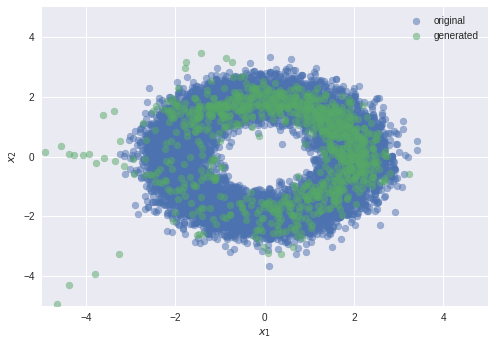

In [34]:
import matplotlib.pyplot as plt
Nsamples = 1000
z = Variable(torch.randn(Nsamples, Nvars), volatile=True)
x = model.forward(z)
plt.figure()
plt.scatter(x_data[:,0], x_data[:,1], alpha=0.5, label='original')
plt.scatter(x[:,0], x[:,1], alpha=0.5, label='generated')
plt.xlim([-5, 5])
plt.ylim([-5, 5])

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()